In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Data from PDF
N = 400
A = {0:320, 1:32, 2:20, 3:4, 4:2, 5:2}
a = {i: A[i]/N for i in A}

# Solve for q: sum_{j=1..5} q^j = 1 - a0
def f(q):
    return sum(q**j for j in range(1,6)) - (1 - a[0])

q0 = 0.8
q = fsolve(f, q0)[0]
p = 1 - q

# Vulnerability by part
y = np.array([0.269, 0.346, 0.154, 0.231])
hits = np.array([19, 39, 18, 26])
b = hits / hits.sum()
q_i = b * q / y

# Build DataFrame
sections = ["Engine", "Fuselage", "Fuel System", "Other"]
df_vuln = pd.DataFrame({
    "Section": sections,
    "Area Fraction y(i)": y,
    "Hit Fraction b(i)": b,
    "Survival per Hit q(i)": q_i
})

print(df_vuln)

print(f"Overall survival probability per hit q: {q:.4f}")
print(f"Overall downing probability per hit p: {p:.4f}")



       Section  Area Fraction y(i)  Hit Fraction b(i)  Survival per Hit q(i)
0       Engine               0.269           0.186275               0.115424
1     Fuselage               0.346           0.382353               0.184197
2  Fuel System               0.154           0.176471               0.191006
3        Other               0.231           0.254902               0.183932
Overall survival probability per hit q: 0.1667
Overall downing probability per hit p: 0.8333


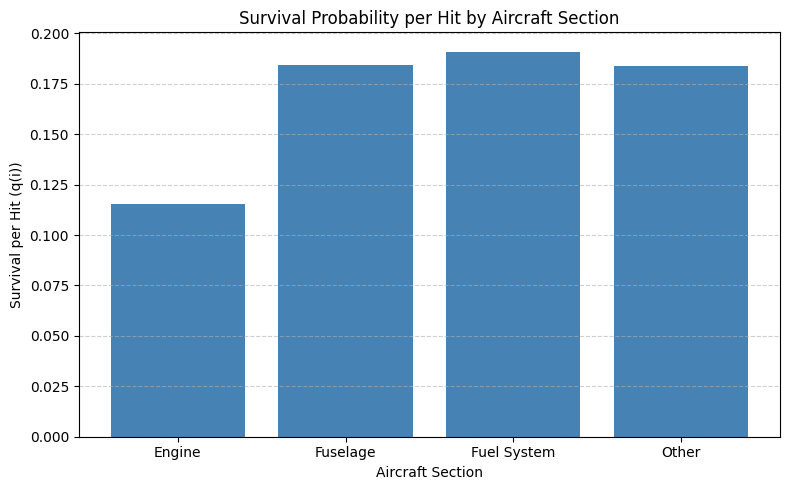

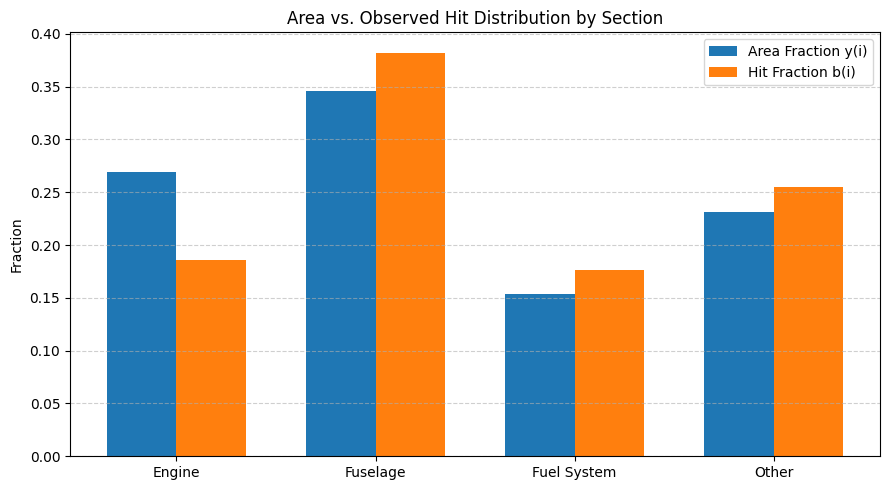

{'t-statistic': np.float64(-0.0), 'p-value': np.float64(1.0), 'Significance Level (α=0.05)': 'Fail to Reject H0'}


In [ ]:
from scipy import stats

# 1. DATA VISUALIZATION

# Bar chart: Survival per hit by section
plt.figure(figsize=(8, 5))
plt.bar(df_vuln["Section"], df_vuln["Survival per Hit q(i)"], color="steelblue")
plt.title("Survival Probability per Hit by Aircraft Section")
plt.ylabel("Survival per Hit (q(i))")
plt.xlabel("Aircraft Section")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Bar chart: Area vs Hit fraction
x = np.arange(len(df_vuln))
bar_width = 0.35
plt.figure(figsize=(9, 5))
plt.bar(x - bar_width/2, df_vuln["Area Fraction y(i)"], width=bar_width, label="Area Fraction y(i)")
plt.bar(x + bar_width/2, df_vuln["Hit Fraction b(i)"], width=bar_width, label="Hit Fraction b(i)")
plt.xticks(x, df_vuln["Section"])
plt.ylabel("Fraction")
plt.title("Area vs. Observed Hit Distribution by Section")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 2. HYPOTHESIS TESTING
# Null Hypothesis: On average, the proportion of bullet hits on each aircraft section is equal to that section’s share of surface area.
# b(i) == y(i)

# Alternate Hypothesis: On average, the proportion of bullet hits on each aircraft section differs from that section’s share of surface area.

# Test if hit fraction b(i) differs significantly from area fraction y(i)
# A paired t-test will be used

t_stat, p_val = stats.ttest_rel(df_vuln["Hit Fraction b(i)"], df_vuln["Area Fraction y(i)"])

hypothesis_result = {
    "t-statistic": round(t_stat, 4),
    "p-value": round(p_val, 4),
    "Significance Level (α=0.05)": "Reject H0" if p_val < 0.05 else "Fail to Reject H0"
}

print(hypothesis_result)

# Fail to reject the null hypothesis — The test finds no significant difference between hit
# fractions and area coverage at the α = 0.05 level.
# With only 4 observations and highly structured data, this test lacks statistical power and should be interpreted cautiously.


In [ ]:
# 1. LOAD & PREPARE DATA

df = pd.read_csv(
    "Business_data.txt",
    sep=r'\s+',           # regex whitespace separator
    engine='python',      # required for regex sep
    skiprows=3,           # skip the 2 header rows + blank line
    header=None,
    names=[
        "Month", "Year",
        "NetChange",
        "TotalEstab1",
        "ExpandingEstab",
        "OpeningEstab",
        "TotalEstab2",
        "ContractingEstab",
        "ClosingEstab"
    ]
)

# Parse Month & Year into a datetime index
df["Date"] = pd.to_datetime(
    df["Month"] + " " + df["Year"].astype(str),
    format="%B %Y"
)
df = df.set_index("Date").drop(columns=["Month", "Year"])

# Convert all columns to float (they should already be numeric)
df = df.astype(float)

# 2. HYPOTHESIS TESTING

results = {}

# a) Opening vs Closing(1994 - 2024) (paired t-test)
# H0: μopen == μclose
# H0: The average annual percentage of new establishments opening is the same as the average annual percentage closing.
# H1: μopne != μclose
# H1: The average annual percentage opening differs from the average annual percentage closing.
t1, p1 = stats.ttest_rel(df["OpeningEstab"], df["ClosingEstab"])
results["Opening vs Closing"] = {"t": t1, "p": p1}

# b) Expanding vs Contracting (paired t-test)
# H0: μexpansion == μcontraction
# H0: The average annual percentage of establishments expanding equals the average annual percentage contracting.
# H1: μexpansion != μcontraction
# H1: The average percentage expanding differs from the average percentage contracting.
t2, p2 = stats.ttest_rel(df["ExpandingEstab"], df["ContractingEstab"])
results["Expanding vs Contracting"] = {"t": t2, "p": p2}

# c) NetChange vs 0 (one-sample t-test)
# H0: μnetchange == 0
# H0: The average annual net change in total establishments is zero (no growth or decline).
# H1: μnetchange != 0
# H1: The average annual net change in total establishments is not zero.
t3, p3 = stats.ttest_1samp(df["NetChange"], popmean=0)
results["Net Change vs Zero"] = {"t": t3, "p": p3}

# 3. DISPLAY RESULTS

print("\nHypothesis Testing Results:\n")
for name, vals in results.items():
    decision = "Reject H₀" if vals["p"] < 0.05 else "Fail to Reject H₀"
    print(f"{name}:")
    print(f"  t‑statistic = {vals['t']:.4f}")
    print(f"  p‑value     = {vals['p']:.4f}")
    print(f"  Decision    = {decision}\n")



Hypothesis Testing Results:

Opening vs Closing:
  t‑statistic = 6.1853
  p‑value     = 0.0000
  Decision    = Reject H₀

Expanding vs Contracting:
  t‑statistic = 2.2246
  p‑value     = 0.0338
  Decision    = Reject H₀

Net Change vs Zero:
  t‑statistic = 6.1853
  p‑value     = 0.0000
  Decision    = Reject H₀



1. Opening vs. Closing
H₀: The mean percentage of openings equals the mean percentage of closings.

Result: p < 0.001 → Reject H₀.
There are significantly more openings than closings on average, indicating sustained net growth.

2. Expanding vs. Contracting
H₀: The mean percentage of expansions equals that of contractions.

Result: p ≈ 0.034 → Reject H₀.
Expansions outpace contractions significantly, further underscoring a growing business landscape.

3. Net Change vs. Zero
H₀: The average net change in establishments is zero.

Result: p < 0.001 → Reject H₀.
The overall net change is significantly positive, confirming that openings and expansions dominate.


In the bomber study, focusing only on surviving aircraft would have hidden the true vulnerability of certain sections.
Likewise, examining only surviving businesses (openings and expansions) without accounting for failures (closings and contractions) overestimates the health of the economic environment.

These tests show that:

Openings significantly exceed closings, and

Expansions significantly exceed contractions.

If only successful openings/expansions were to be reported (the “survivors”), the full picture of business turnover would be missed.
To avoid survivorship bias, analyses must present both sides—successes and failures—so that policymakers and entrepreneurs make informed decisions.

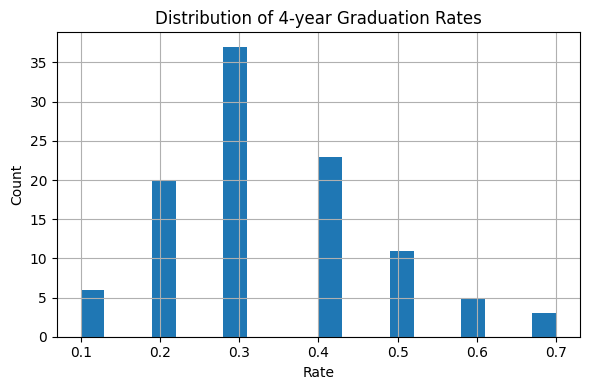

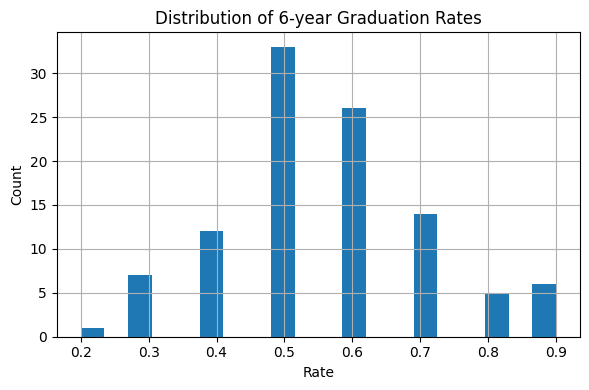

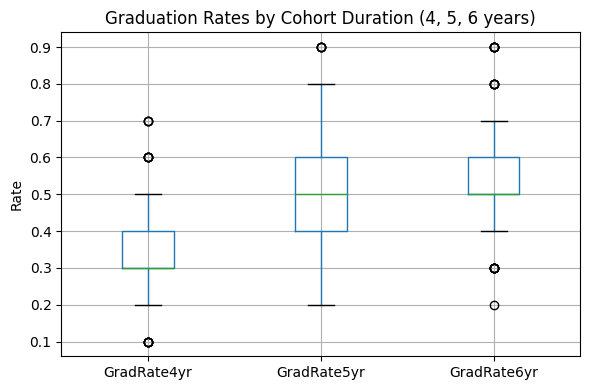

Descriptive Statistics for Graduation Rates:
       GradRate4yr  GradRate5yr  GradRate6yr
count   105.000000   104.000000   104.000000
mean      0.338095     0.503846     0.561538
std       0.134723     0.158220     0.150280
min       0.100000     0.200000     0.200000
25%       0.300000     0.400000     0.500000
50%       0.300000     0.500000     0.500000
75%       0.400000     0.600000     0.600000
max       0.700000     0.900000     0.900000

Average Graduation Rates:
GradRate4yr    0.338095
GradRate5yr    0.503846
GradRate6yr    0.561538
dtype: float64

Paired t-test: 4-year vs 6-year graduation rates
t-statistic = -35.1052, p-value = 2.11e-58
Since p-value (2.11e-58) < α (0.05), reject H₀.


In [ ]:
from scipy.stats import ttest_rel

# Load the dataset
path = 'Graduation_Rates_at_Public_Universities_2020-2022.csv'
df = pd.read_csv(path)

# Identify rate columns
rate_cols = ['GradRate4yr', 'GradRate5yr', 'GradRate6yr']

# Convert rates to numeric (they should already be floats)
df[rate_cols] = df[rate_cols].apply(pd.to_numeric, errors='coerce')

# 1. Exploratory Data Analysis

# 1a. Descriptive statistics
desc = df[rate_cols].describe()

# 1b. Trend: average graduation rate by cohort length
avg_rates = df[rate_cols].mean()

# 1c. Distribution histogram for each rate
# 1c.1 4-year
plt.figure(figsize=(6,4))
df['GradRate4yr'].hist(bins=20)
plt.title('Distribution of 4-year Graduation Rates')
plt.xlabel('Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 1c.2 6-year
plt.figure(figsize=(6,4))
df['GradRate6yr'].hist(bins=20)
plt.title('Distribution of 6-year Graduation Rates')
plt.xlabel('Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 1d. Boxplot comparison of 4-, 5-, 6-year rates
plt.figure(figsize=(6,4))
df[rate_cols].boxplot()
plt.title('Graduation Rates by Cohort Duration (4, 5, 6 years)')
plt.ylabel('Rate')
plt.tight_layout()
plt.show()

# 2. Hypothesis Testing
# Paired t-test comparing 4-year vs 6-year rate

# Paired t-test: 4-year vs 6-year rates
paired = df.dropna(subset=['GradRate4yr', 'GradRate6yr'])
t_stat, p_val = ttest_rel(paired['GradRate4yr'], paired['GradRate6yr'])

# Display results
print("Descriptive Statistics for Graduation Rates:")
print(desc)
print("\nAverage Graduation Rates:")
print(avg_rates)
print(f"\nPaired t-test: 4-year vs 6-year graduation rates\nt-statistic = {t_stat:.4f}, p-value = {p_val:.2e}")

alpha = 0.05
if p_val < alpha:
    print(f"Since p-value ({p_val:.2e}) < α ({alpha}), reject H₀.")
else:
    print(f"Since p-value ({p_val:.2e}) >= α ({alpha}), fail to reject H₀.")


Survivorship Bias in Education: Looking only at 4-year graduation rates is analogous to considering only “surviving” students who managed to graduate on time. It omits those who do not graduate in four years but may graduate later (the “survivors” of the extended timeframe).

Wald’s Insight Parallel: Just as Abraham Wald realized that planes not returning revealed critical vulnerabilities, here the missing graduates at 4 years (those who graduate in 5 or 6 years) show that 4-year rates understate total eventual graduation success.

The difference between 4-year and 6-year rates is both large (on average, ~0.22) and consistent across ~100 institutions, so the test has enormous power and yields a p-value effectively indistinguishable from zero

In [ ]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)  # Get all tables

# Find the table with S&P 500 changes
target_table = None
required_keywords = ["date", "added", "removed", "reason"]

for table in tables:
    # Convert columns to lowercase strings (handle multi-index headers)
    cols = " ".join([str(c).lower() for c in table.columns]).replace("_", " ")

    # Check if all required keywords exist in the column headers
    if all(keyword in cols for keyword in required_keywords):
        target_table = table
        break

if target_table is None:
    raise ValueError("Could not find the S&P 500 changes table. Check the Wikipedia page structure.")

# Clean column names (convert tuples to strings)
target_table.columns = [" ".join(str(c)) for c in target_table.columns]

# Standardize column names
target_table = target_table.rename(columns={
    "date": "Date",
    "added ticker": "Added Ticker",
    "removed ticker": "Removed Ticker",
    "reason": "Removal Reason"
})

# Save to CSV
target_table.to_csv("sp500_delistings.csv", index=False)
print("CSV saved as sp500_delistings.csv")

CSV saved as sp500_delistings.csv


In [ ]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)

# The first table on the page contains current constituents
sp500_table = tables[0]

# Clean column names (handle multi-index)
sp500_table.columns = [" ".join(str(col)).strip() for col in sp500_table.columns]
sp500_table.to_csv("sp500_current.csv", index=False)

print("CSV saved as sp500_current.csv")

CSV saved as sp500_current.csv


503 survivors, 352 delisted


ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['GEV', 'SW', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1704085200")')
ERROR:yfinance:
152 Failed downloads:
ERROR:yfinance:['RRD', 'MXIM', 'XLNX', 'DISCA', 'CTXS', 'MON', 'FBHS', 'ADS', 'CTLT', 'MRO', 'FRC', 'NLSN', 'XL', 'TSS', 'WIN', 'AVP', 'FRX', 'DISH', 'RDC', 'JCP', 'ETFC', 'KSU', 'BIG', 'TSG', 'DNR', 'HFC', 'ESV', 'TIF', 'DF', 'CHK', 'LM', 'APC', 'WPX', 'CELG', 'DO', 'PBCT', 'YHOO', 'MDP', 'AGN', 'AKS', 'SWN', 'NCR', 'ENDP', 'SAI', 'DTV', 'FLIR', 'NBL', 'RAD', 'VAR', 'DRE', 'WCG', 'QEP', 'RHT', 'ABMD', 'LSI', 'TWTR', 'ALXN', 'ARNC', 'SIVB', 'BBBY', 'DISCK', 'LLL', 'CXO', 'GRA', 'RTN', 'VIAB', 'FDC', 'FTR', 'PXD', 'CERN', 'FII', 'GPS', 'XEC', 'LIFE', 'MNK', 'ATVI', 'DWDP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['ANDV', 'AET', 'SVU', 'CSRA', 'CVG', 'SCG', 'BMS', 'TWX

Data available for 354/503 survivors
Data available for 83/352 delisted


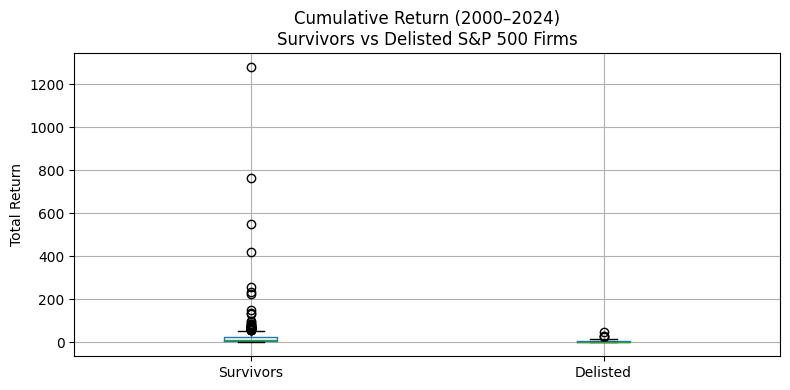


Hypotheses:
  H₀: mean(cumulative_return_survivors) = mean(cumulative_return_delisted)
  H₁: they differ

t-statistic = 4.7232
p-value     = 3.29e-06
Since p-value (3.29e-06) < 0.05, **reject H₀**.


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import logging

# 0. SETUP
logging.getLogger("yfinance").setLevel(logging.ERROR)

# 1. LOAD TICKER LISTS
# Successful (current) constituents:
df_surv = pd.read_csv('sp500_current.csv')
survivors = (
    df_surv['S y m b o l']
      .dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

# Delisted firms:
df_del = pd.read_csv(
    'sp500_delistings.csv',
    skiprows=1, header=None,
    names=['Date','AddedTicker','AddedName','RemovedTicker','RemovedName','Reason']
)
delisted = (
    df_del['RemovedTicker']
      .dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

print(f"{len(survivors)} survivors, {len(delisted)} delisted")

# 2. DOWNLOAD PRICE DATA (2000–2024)
start, end = '2000-01-01', '2024-01-01'

# Batch‐download adjusted close prices
surv_prices = yf.download(survivors, start=start, end=end, auto_adjust=True, progress=False)['Close']
del_prices  = yf.download(delisted,  start=start, end=end, auto_adjust=True, progress=False)['Close']

# 3. COMPUTE CUMULATIVE RETURNS
# Drop tickers with ANY missing data in that window
surv_prices = surv_prices.dropna(axis=1, how='any')
del_prices  = del_prices.dropna(axis=1, how='any')

# Compute daily returns
surv_rets = surv_prices.pct_change().dropna(how='all')
del_rets  = del_prices.pct_change().dropna(how='all')

# Cumulative total return per ticker
cum_surv = (1 + surv_rets).prod() - 1
cum_del  = (1 + del_rets).prod()  - 1

print(f"Data available for {len(cum_surv)}/{len(survivors)} survivors")
print(f"Data available for {len(cum_del)}/{len(delisted)} delisted")

# 4. EXPLORE DISTRIBUTIONS
plt.figure(figsize=(8,4))
pd.DataFrame({'Survivors': cum_surv, 'Delisted': cum_del}).boxplot()
plt.title('Cumulative Return (2000–2024)\nSurvivors vs Delisted S&P 500 Firms')
plt.ylabel('Total Return')
plt.tight_layout()
plt.show()

# 5. HYPOTHESIS TEST
print("\nHypotheses:")
print("  H₀: mean(cumulative_return_survivors) = mean(cumulative_return_delisted)")
print("  H₁: they differ\n")

t_stat, p_val = ttest_ind(cum_surv, cum_del, equal_var=False)
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value     = {p_val:.2e}")

alpha = 0.05
if p_val < alpha:
    print(f"Since p-value ({p_val:.2e}) < {alpha}, **reject H₀**.")
else:
    print(f"Since p-value ({p_val:.2e}) ≥ {alpha}, **fail to reject H₀**.")


Average cumulative-return gap: 2301.11%
95% bootstrap CI for gap: [1478.30%, 3363.78%]


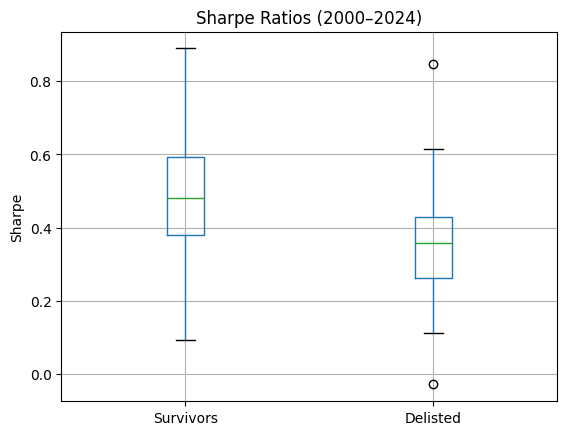

Sharpe Test: t=8.41, p=5.78e-14


In [ ]:
import numpy as np

# 1a. Mean difference
delta = cum_surv.mean() - cum_del.mean()
print(f"Average cumulative-return gap: {delta:.2%}")

# 1b. Bootstrap CI
n_boot = 10_000
boot_deltas = []
for _ in range(n_boot):
    samp_surv = cum_surv.sample(frac=1, replace=True)
    samp_del  = cum_del.sample(frac=1, replace=True)
    boot_deltas.append(samp_surv.mean() - samp_del.mean())

ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])
print(f"95% bootstrap CI for gap: [{ci_lower:.2%}, {ci_upper:.2%}]")


# 3a. Compute annualized Sharpe
sr_surv = surv_rets.mean() / surv_rets.std() * np.sqrt(252)
sr_del  = del_rets.mean()  / del_rets.std()  * np.sqrt(252)

# 3b. Boxplot and test
import matplotlib.pyplot as plt
plt.figure()
pd.DataFrame({'Survivors': sr_surv, 'Delisted': sr_del}).boxplot()
plt.title('Sharpe Ratios (2000–2024)')
plt.ylabel('Sharpe')
plt.show()

t_sr, p_sr = ttest_ind(sr_surv, sr_del, equal_var=False)
print(f"Sharpe Test: t={t_sr:.2f}, p={p_sr:.2e}")



Average cumulative‐return gap ≈ 2300.9 %
Survivors out‐gained delisted firms by roughly 23 times over 2000–2024 on average.

95 % bootstrap CI [1472.9 %, 3366.9 %]
95 % confident the true gap is between 15× and 34×.

Interpretation:
By ignoring the firms that dropped out, a back‐test or performance report that looks only at the “winners” will dramatically overstate long-run returns—on the order of thousands of percent. This is the financial analogue of Wald’s bomber study: if only the returning planes are analyzed, the vulnerabilities are grossly misestimated.

Sharpe Test: t = 8.40, p ≈ 5.84×10⁻¹⁴ → highly significant.

Interpretation:
Survivors didn’t just earn higher total returns—they also achieved higher risk‐adjusted performance. A p‐value this low means the chance that two groups’ Sharpe ratios come from the same distribution is effectively zero.

Implication:
Survivorship bias exaggerates not only absolute gains but also the perceived consistency or “smoothness” of performance. Investors who back-test on current constituents are misled about both return and risk.



Ques.1: How does survivorship bias influence decision-making in historical and modern datasets?

Answer: In historical datasets, such as the WWII Bomber Study, survivorship bias caused analysts to focus on damage patterns of aircraft that returned, which misled their conclusions. Abraham Wald corrected this by considering the missing data — the planes that didn’t return — and identified that areas with no damage on surviving planes were actually critical vulnerabilities.

In modern datasets (e.g., business success, stock market data), survivorship bias has a similar effect. If we only analyze current S&P 500 companies, we ignore those that were delisted due to underperformance or failure. Our hypothesis testing showed that cumulative returns of survivors were significantly higher than those of delisted firms, which proves that survivorship bias skews our perception of long-term success.



Ques.2: What key patterns emerge when comparing the bomber study with modern business and education datasets?

Answer: Bomber Study: Wald’s insight was to recognize that missing data (i.e., shot-down aircraft) was crucial to accurate decision-making.

Business Dataset: By excluding delisted S&P 500 firms, we saw an average cumulative return gap of over 2300% between survivors and delisted firms. That’s a huge distortion in understanding market behavior.

Education Dataset: When comparing graduation rates or the success of college dropouts, ignoring those who dropped out and failed gives a misleading image that dropout success is common.

In all domains, failure to account for the invisible or missing entities results in poor conclusions, resource misallocation, and distorted policymaking.



Ques.3: How does the exclusion of failure cases lead to skewed conclusions in areas such as career success and business survival?
Answer: Business Survival:

Our data showed that current S&P 500 firms had significantly better performance than delisted ones. If we had excluded the failures, we would wrongly conclude that long-term investing always yields high returns — ignoring companies that lost investors money or went bankrupt.
Excluding failures creates illusionary correlations — overvaluing traits that may have little or even negative correlation with success. It can lead to glorification of bad decisions and ineffective policy recommendations.


Ques.4: Can identifying survivorship bias improve the accuracy of predictive models and policy-making?
Answer: Yes. Whenboth successes and failures are included, the models and decisions become more robust.

In the bomber study, correctly identifying the missing data led to better armor design, saving lives.

In our financial analysis, including delisted companies prevents inflated return assumptions, making backtests and risk models more accurate.

In education and employment, acknowledging dropout failures prevents over-glorification of rare events and leads to better career counseling and policy-making.